<a href="https://colab.research.google.com/github/WasifAsi/DSGP_GP-19/blob/deeplabv3%2B/DeepLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Imports**

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms
from PIL import Image
import cv2
from google.colab import drive
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pickle
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

# Mount Google Drive
drive.mount('/content/drive')

# Create model directory in Google Drive
MODEL_SAVE_PATH = '/content/drive/MyDrive/shoreline_models'
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Set hyperparameters
learning_rate = 0.0005
batch_size = 6  # decreased from 8
num_epochs = 200
image_size = 540  # Increased from 240

#**Loss Functions**

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.003, gamma=5.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, pred, target):
        # Apply sigmoid
        pred_prob = torch.sigmoid(pred)

        # Calculate pt
        pt = target * pred_prob + (1 - target) * (1 - pred_prob)

        # Calculate focal weight
        focal_weight = (1 - pt) ** self.gamma

        # Calculate loss
        loss = -self.alpha * focal_weight * torch.log(pt + 1e-12)

        return loss.mean()

# Combine with Dice Loss
class CombinedFocalDiceLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2.0, dice_weight=0.5):
        super().__init__()
        self.focal = FocalLoss(alpha=alpha, gamma=gamma)
        self.dice_weight = dice_weight

    def forward(self, pred, target):
        focal_loss = self.focal(pred, target)

        pred_prob = torch.sigmoid(pred)
        intersection = (pred_prob * target).sum()
        dice_loss = 1 - (2. * intersection + 1) / (pred_prob.sum() + target.sum() + 1)

        return focal_loss + self.dice_weight * dice_loss

#**Model Components**

In [2]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation):
        super().__init__(
            nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

class ASPPPooling(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        size = x.shape[-2:]
        for mod in self:
            x = mod(x)
        return F.interpolate(x, size=size, mode='bilinear', align_corners=False)

class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates, out_channels=256):
        super().__init__()
        modules = []
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()))

        rates = tuple(atrous_rates)
        for rate in rates:
            modules.append(ASPPConv(in_channels, out_channels, rate))

        modules.append(ASPPPooling(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)

        self.project = nn.Sequential(
            nn.Conv2d(len(self.convs) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5))

    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        return self.project(res)


#**Main Model**

In [3]:
class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()

        # Initial conv layers with reduced stride
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

        # ResNet-like blocks with modified strides
        self.layer1 = self._make_layer(64, 64, 3, stride=1)
        self.layer2 = self._make_layer(64, 128, 4, stride=2)
        self.layer3 = self._make_layer(128, 256, 6, stride=2)
        self.layer4 = self._make_layer(256, 512, 3, stride=1)

        # ASPP
        self.aspp = ASPP(512, [6, 12, 18])  # Reduced dilation rates

        # Low-level features conversion
        self.low_level_conv = nn.Sequential(
            nn.Conv2d(64, 48, 1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU()
        )

        # Auxiliary decoder
        self.aux_decoder = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv2d(256, 1, 1)
        )

        # Main decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(304, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(256, num_classes, 1)
        )

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        input_size = x.size()[-2:]

        # Initial convolutions
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        # Backbone
        low_level_feat = self.layer1(x)
        x = self.layer2(low_level_feat)
        x = self.layer3(x)
        x = self.layer4(x)

        # Auxiliary output
        aux_out = self.aux_decoder(x)
        aux_out = F.interpolate(aux_out, size=input_size, mode='bilinear', align_corners=False)

        # ASPP
        x = self.aspp(x)

        # Decoder
        x = F.interpolate(x, size=low_level_feat.shape[2:], mode='bilinear', align_corners=False)
        low_level_feat = self.low_level_conv(low_level_feat)
        x = torch.cat([x, low_level_feat], dim=1)
        x = self.decoder(x)

        # Final upsampling
        x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=False)

        if self.training:
            return x, aux_out
        return x

#**Dataset and transform**

In [ ]:
class ShorelineDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 128).astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

#**Early stopping**

In [ ]:
class EarlyStopping:
    def __init__(self, patience=35, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return self.early_stop

#**Dataset Transform and Loader function**

In [ ]:
def get_preprocessing_transform(image_size=540):
    return A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
        ToTensorV2(),
    ])

def get_training_transform(image_size=540):
    return A.Compose([
        A.Resize(image_size, image_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.OneOf([
            A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=0.5),
        ], p=0.3),
        A.OneOf([
            A.GaussianBlur(blur_limit=3, p=0.5),
            A.MedianBlur(blur_limit=3, p=0.5),
            A.MotionBlur(blur_limit=3, p=0.5),
        ], p=0.3),
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
            A.HueSaturationValue(p=0.5),
        ], p=0.3),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
        ToTensorV2(),
    ])

def prepare_dataloaders(train_image_dir, train_mask_dir,
                     val_image_dir, val_mask_dir,
                     test_image_dir, test_mask_dir,
                     batch_size=8, image_size=256):
    """
    Prepare dataloaders using the specified directory structure
    """
    # Create datasets
    train_dataset = ShorelineDataset(
        train_image_dir,
        train_mask_dir,
        transform=get_training_transform(image_size)
    )

    val_dataset = ShorelineDataset(
        val_image_dir,
        val_mask_dir,
        transform=get_preprocessing_transform(image_size)
    )

    test_dataset = ShorelineDataset(
        test_image_dir,
        test_mask_dir,
        transform=get_preprocessing_transform(image_size)
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    return train_loader, val_loader, test_loader

#**Training function**

In [ ]:
def train_model(model, train_loader, val_loader, device, num_epochs=200, learning_rate=5e-4):
    # Calculate class weights
    # Initialize loss function and optimizer
   # No class weight calculation needed
    criterion = CombinedFocalDiceLoss(alpha=0.003, gamma=5.0, dice_weight=0.5)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
    early_stopping = EarlyStopping(patience=25, min_delta=1e-4)

    best_loss = float('inf')
    training_data = {
        "loss": [],
        "epoch": [],
        "lr": [],
        "val_loss": []
    }


    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images = images.to(device)
            masks = masks.float().to(device)

            optimizer.zero_grad()
            main_outputs, aux_outputs = model(images)

            # Calculate main and auxiliary losses
            main_loss = criterion(main_outputs, masks.unsqueeze(1))
            aux_loss = criterion(aux_outputs, masks.unsqueeze(1))
            loss = main_loss + 0.4 * aux_loss

            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.float().to(device)
                outputs = model(images)
                # During validation, model returns only main output
                val_loss += criterion(outputs, masks.unsqueeze(1)).item()

        epoch_loss = total_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Training Loss: {epoch_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

        scheduler.step()

        # Save best model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), os.path.join(MODEL_SAVE_PATH, 'best_shoreline_deeplabv3.pt'))

        # Early stopping check
        if early_stopping(val_loss):
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

        # Update training data
        training_data["loss"].append(epoch_loss)
        training_data["epoch"].append(epoch)
        training_data["lr"].append(optimizer.param_groups[0]['lr'])
        training_data["val_loss"].append(val_loss)

        # Save training history periodically
        if epoch % 5 == 0:
            with open(os.path.join(MODEL_SAVE_PATH, 'training_history_deeplabv3.pkl'), 'wb') as f:
                pickle.dump(training_data, f)

    # Save final model and training history
    torch.save(model.state_dict(), os.path.join(MODEL_SAVE_PATH, 'final_shoreline_deeplabv3.pt'))
    with open(os.path.join(MODEL_SAVE_PATH, 'final_training_history_deeplabv3.pkl'), 'wb') as f:
        pickle.dump(training_data, f)

    return model, training_data

#**Main function**

In [ ]:
def main():
    # Set paths
    train_image_dir = '/content/drive/MyDrive/training_satellite'
    train_mask_dir = '/content/drive/MyDrive/training_mask'
    val_image_dir = '/content/drive/MyDrive/validation_satellite'
    val_mask_dir = '/content/drive/MyDrive/validation_mask'
    test_image_dir = '/content/drive/MyDrive/testing_satellite'
    test_mask_dir = '/content/drive/MyDrive/testing_mask'

    # Create model directory
    MODEL_SAVE_PATH = '/content/drive/MyDrive/shoreline_models'
    os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

    # Prepare dataloaders
    train_loader, val_loader, test_loader = prepare_dataloaders(
        train_image_dir=train_image_dir,
        train_mask_dir=train_mask_dir,
        val_image_dir=val_image_dir,
        val_mask_dir=val_mask_dir,
        test_image_dir=test_image_dir,
        test_mask_dir=test_mask_dir,
        batch_size=batch_size,
        image_size=image_size
    )

    # Initialize model
    model = DeepLabV3Plus(num_classes=1).to(device)

    # Train model
    print("Starting training...")
    trained_model, training_history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        num_epochs=num_epochs,
        learning_rate=learning_rate
    )

if __name__ == "__main__":
    main()

#**Plotting**

Testing a new image

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-8-3e78f8aa057f>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/shoreline_models/best_shoreline_dee

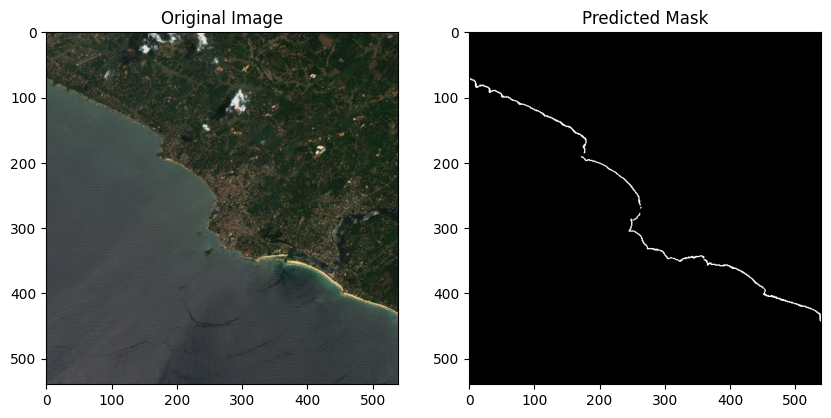

In [8]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepLabV3Plus(num_classes=1)
model.load_state_dict(torch.load("/content/drive/MyDrive/shoreline_models/best_shoreline_deeplabv3.pt", map_location=device))
model.to(device)
model.eval()

# Image Preprocessing
def preprocess_image(image_path, image_size=540):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    transform = A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

    augmented = transform(image=image)
    image = augmented["image"].unsqueeze(0)  # Add batch dimension
    return image.to(device), image.shape[1:]  # Return tensor & original shape

# Mask Prediction
def predict_mask(model, image_tensor):
    with torch.no_grad():
        output = model(image_tensor)
        output = torch.sigmoid(output)  # Convert logits to probabilities
        mask = output.squeeze().cpu().numpy()  # Remove batch & channel dimensions
        return (mask > 0.5).astype(np.uint8)  # Threshold at 0.5

# Display Results
def display_result(image_path, mask):
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    #resizing original image
    original_image_resized=cv2.resize(original_image,(540,540))

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image_resized)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Predicted Mask")

    plt.show()

# Run Inference
image_path = "sentinel2_void_2019-03-27_Beruwala.jpg"  # Update with test image path
image_tensor, _ = preprocess_image(image_path)
predicted_mask = predict_mask(model, image_tensor)
display_result(image_path, predicted_mask)
